# Code to generate figure 3 in the publication
Analysis of sensitive enzymes and reactions in the model simulations of protein overexpression

In [8]:
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import pandas as pd
import numpy as np
import os
import sys
from optlang.symbolics import Zero

from PAModelpy.configuration import Config
from PAModelpy.EnzymeSectors import ActiveEnzymeSector, UnusedEnzymeSector, TransEnzymeSector, CustomSector
from PAModelpy.Enzyme import Enzyme

sys.path.append('../Scripts/')
from pam_generation import set_up_ecoli_pam

DATA_DIR = os.path.join(os.path.split(os.getcwd())[0], 'Data')
eGFP_MW = 2.8*1e4 #g/mol
eGFP_RANGE = np.arange(0,0.15,0.01)
GLC_CONC = 9.81 #mmol_glc/gcdw/h
eGFP_BEINICK_DATA_PATH = os.path.join(DATA_DIR, 'eGFP_expression_Bienick2014.xls')
eGFP_SEQ_PATH = os.path.join(DATA_DIR, 'eGFP_protein_sequence.txt')
BIOMASS_RXNID = Config.BIOMASS_REACTION

In [9]:
BIOMASS_RXNID = 'BIOMASS_Ec_iML1515_core_75p37M'

## sensitivities of protein overexpression in the PAM of E.coli

### 1. Usefull functions

#### 1.1 Sensitivity analysis

In [10]:
def calculate_sensitivities(pamodel):
    #initialize objects for storing information
    results_df = pd.DataFrame(columns = ['eGFP', 'mu', 'mu_normalized'])
    Ccsc = [] #capacity sensitivity coefficients
    Cvsc = [] #variable sensitivity coefficients
    x_axis_vs = []
    x_axis_csc = []
    y_axis = []
    fluxes = []
    
    # #set glucose uptake rate
    # pamodel.change_reaction_bounds(rxn_id = 'EX_glc__D_e', 
    #                                         lower_bound = -100, upper_bound = 0)
    
    #set glucose uptake rate
    pamodel.change_reaction_bounds(rxn_id = 'EX_glc__D_e', 
                                            lower_bound = -GLC_CONC, upper_bound = -GLC_CONC)
    
    
    for conc in eGFP_RANGE:
        print('Running simulations with the following eGFP concentration: ', conc, 'mmol/g_cdw/h')
        with pamodel:
            #change eGFP concentration
            pamodel.constraints['eGFP_min'].ub = -conc*1e3
            sol_pam = pamodel.optimize()
            #check if simulation is optimal
            if pamodel.solver.status == 'optimal': 
                y_axis += [conc]
                
                # save data
                fluxes.append(sol_pam.fluxes) # flux distributions
    
                # calculate normalized growth rate
                mu = pamodel.reactions.get_by_id(BIOMASS_RXNID).flux
                if conc == 0:
                    mu_normalized = 1
                    mu_wt = mu
                else:
                    mu_normalized = mu/mu_wt
                results_df.loc[len(results_df)] = [conc,mu, mu_normalized]
    
                #save sensitivities
                Ccsc_new = list()
                capacity_coeff = pamodel.capacity_sensitivity_coefficients
                for csc in ['flux_ub', 'flux_lb', 'enzyme_max','enzyme_min','proteome', 'sector']:
                    if csc == 'EC_min_f':
                        Ccsc_new += [-coef for coef in capacity_coeff[capacity_coeff['constraint'] == csc].coefficient.to_list()]
                    else:
                        Ccsc_new += capacity_coeff[capacity_coeff['constraint'] == csc].coefficient.to_list()
                
                Ccsc += [Ccsc_new]
                
                variable_coeff = pamodel.variable_sensitivity_coefficients
                Cvsc_new = list()
                for vsc in ['flux', 'enzyme', 'sector']:
                    Cvsc_new += variable_coeff[variable_coeff['constraint'] == vsc].coefficient.to_list()
                Cvsc += [Cvsc_new]
                
                print('Sum of capacity sensitivity coefficients: \t \t \t \t \t \t \t', round(sum(Ccsc_new),6))
                print('Sum of variable sensitivity coefficients: \t \t \t \t \t \t \t', round(sum(Cvsc_new),6), '\n')

    return {'Ccsc':Ccsc, 'Cvsc':Cvsc, 'y_axis':y_axis, 'fluxes':fluxes, 'capacity coefficients':capacity_coeff, 
            'variable coefficients':variable_coeff, 'results': results_df}
            

In [11]:
def find_nonzero_sensitivities(Cv, x_axis):
    indices = []
    for row in Cv:
        for index, coeff in enumerate(row):
            if abs(coeff)>0.09 and index not in indices:
                indices.append(index)
    
    coeff_nonzero = []
    for row in Cv:
        coeff_nonzero.append([coeff for i, coeff in enumerate(row) if i in indices])
    x_coeff_nonzero = [coeff for i, coeff in enumerate(x_axis) if i in indices]

    return coeff_nonzero, x_coeff_nonzero

In [12]:
def find_top5_sensitivities(Cv, x_axis, yaxis):
    #top 5 enzymes per simulation
    Cv_df = pd.DataFrame(Cv, columns = x_axis, index =yaxis)
    largest = list()
    for i, row in Cv_df.iterrows():
        top5 = abs(row).nlargest()        
        if top5.iloc[0]:
            largest += [index for index, value in top5.items() if abs(value)>0.05]
            print([index for index, value in top5.items() if abs(value)>0.05])
    
    #remove duplicates
    largest_list = list(set(largest))

    #extract non duplicate top5 enzymes
    top5_df = Cv_df[largest_list].T.drop_duplicates().sort_index()
    largest_list = top5_df.index.values

    top5_matrix = [list(row) for i, row in top5_df.iterrows()]
    return top5_matrix, largest_list


#### 1.2 Plotting

In [13]:
def parse_x_axis_heatmap(capacity_coeff, variable_coeff):
    x_axis_vsc = []
    x_axis_csc = []
    
    for csc in ['flux_ub', 'flux_lb', 'enzyme_max','enzyme_min','proteome', 'sector']:
        if csc == 'flux_ub' or csc == 'flux_lb':
            x_axis_csc += [coef+'_'+ csc for coef in capacity_coeff[capacity_coeff['constraint'] == csc].rxn_id.to_list()]
        else:
            x_axis_csc += [coef+'_'+ csc for coef in capacity_coeff[
            capacity_coeff['constraint'] == csc].enzyme_id.to_list()]
    
    for vsc in ['flux', 'enzyme', 'sector']:
        if vsc == 'flux':
            x_axis_vsc += variable_coeff[variable_coeff['constraint'] == vsc].rxn_id.to_list()
        else:
            x_axis_vsc += variable_coeff[
                variable_coeff['constraint'] == vsc].enzyme_id.to_list()
    return x_axis_csc, x_axis_vsc

In [47]:
def make_heatmap_subfigure(results, csc_matrix, vsc_matrix, x_csc, x_vsc, yaxis, fig, grdspc, ylabels = True, cbar =True, title = None,
                           fontsize = 16, vmin = -1.5, vmax = 1.5, annotate = None, phenotype_data = None,cmap = plt.cm.get_cmap('viridis')):
    # fig = plt.figure()

    if cbar:
        gs = gridspec.GridSpecFromSubplotSpec(2, 2, width_ratios=[len(yaxis), 1], 
                                            height_ratios=[len(x_csc), len(x_vsc)], hspace =0, subplot_spec=grdspc)
    else:
        gs = gridspec.GridSpecFromSubplotSpec(2, 1, width_ratios=[len(yaxis)], 
                                            height_ratios=[len(x_csc), len(x_vsc)], hspace =0, subplot_spec=grdspc)

    # gs = gridspec.GridSpec(3, 2, width_ratios=[len(yaxis), 1], height_ratios=[1,len(x_csc), len(x_vsc)], hspace =0)
    
    vsc_ax = fig.add_subplot(gs[1,0]) #VSC heatmap
    csc_ax = fig.add_subplot(gs[0,0],sharex = vsc_ax) #CSC heatmap
    if cbar:
        cbar_ax = fig.add_subplot(gs[0:,1]) #colorbar

    #add annotation for subfigure (A or B)
    if annotate is not None:
        csc_ax.annotate(annotate, xy=(2, 1), xycoords='data',
            xytext=(-0.05,1.1), textcoords='axes fraction',
            va='top', ha='left', fontsize = fontsize+5, weight = 'bold')

    #CAC heatmap
    im_csc = csc_ax.imshow(csc_matrix, aspect="auto", vmin = vmin, vmax =vmax,cmap = cmap)
    if title is not None: csc_ax.set_title(title, fontsize = fontsize*1.5)
    csc_ax.set_yticks(np.arange(len(x_csc)), labels=x_csc, fontsize =fontsize)
    csc_ax.xaxis.set_visible(False)
    if ylabels:
        csc_ax.set_ylabel('CSC', fontsize = fontsize*1.5)

    #Make line between CSC and VSC data more clear
    axis = 'bottom'
    csc_ax.spines[axis].set_linewidth(10)
    csc_ax.spines[axis].set_color("black")
    csc_ax.spines[axis].set_zorder(0)
    
    #VSC heatmap
    im_vsc = vsc_ax.imshow(vsc_matrix, aspect="auto", vmin = vmin, vmax =vmax,cmap = cmap)
    vsc_ax.set_yticks(np.arange(len(x_vsc)), labels=x_vsc, fontsize =fontsize)
    vsc_ax.set_xticks(np.arange(len(yaxis)),labels = yaxis, fontsize =fontsize, rotation=45, ha='right')
    # vsc_ax.set_xlabel('Glucose uptake rate [$mmol_{glc}/g_{CDW}/h$]', fontsize = fontsize)
    if ylabels:
        vsc_ax.set_ylabel('VSC', fontsize = fontsize*1.5)
        
    #colorbar
    if cbar:
        cbar_ax.xaxis.set_visible(False)
        # cbar_ax.yaxis.set_visible(False)
        make_scaled_colorbar(ax=cbar_ax, vmin=vmin, vmax=vmax, fig = fig, fontsize = fontsize,cmap = cmap)

    return fig

In [15]:
def make_scaled_colorbar(ax, fig, cmap = 'viridis', vmin =-1, vmax = 1, fontsize = 16, cbarlabel = 'Allocation Coefficient'):
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm = norm)
    sm.set_array([])
    
    cbar = fig.colorbar(sm, ax =ax, cax=ax, shrink = 1, fraction = 1)
    #setting the fontsize of the colourbar
    cbar.set_label(cbarlabel,fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.ax.yaxis.get_offset_text().set(size=fontsize)

In [16]:
#adjust labels for better readibility
def adjust_heatmap_labels(labels):
    new_labels = labels.copy()

    for i, label in enumerate(labels):
        if label =='EX_glc__D_e' or label[:-3] == 'EX_glc__D_e':
            if label[-1] == 'B': new_labels[i] = 'EX_glc_'+label[-2:]
            else: new_labels[i] = 'EX_glc'
        if label == 'TotalProteinConstraint_proteome':
            new_labels[i] = 'Protein pool'
        if label == 'eGFP_enzyme_min':
            new_labels[i] = 'eGFP_min'
        if label[0].isdigit(): #all enzyme ids start with a digit
            if label == '2.7.3.9':
                new_labels[i] = 'Glucose\ntransport'
            else:
                rxn_ids = pamodel.get_reactions_with_enzyme_id(label)
                rxn_name = pamodel.reactions.get_by_id(rxn_ids[-1]).name.split('(')[0]
                new_labels[i] = '\n'.join([part for part in rxn_name.split(' ')])
    return new_labels

## 1.3 Determining aminoacid content of eGFP

In [17]:
def check_freq(x, total):
    return {c: x.count(c)/total for c in set(x)}

In [18]:
#aminoacid lookup table
aa_lookup ={'V':'VAL', 'I':'ILE', 'L':'LEU', 'E':'GLU', 'Q':'GLN', \
'D':'ASP', 'N':'ASN', 'H':'HIS', 'W':'TRP', 'F':'PHE', 'Y':'TYR',    \
'R':'ARG', 'K':'LYS', 'S':'SER', 'T':'THR', 'M':'MET', 'A':'ALA',    \
'G':'GLY', 'P':'PRO', 'C':'CYS'}

In [19]:
#read amino acid sequence
with open(eGFP_SEQ_PATH) as f:
    lines = f.readlines()
#need to remove document start ('\ufeff') and end ('\n') to only yield the amino acid sequence
aa_seq = lines[0].strip().replace('\ufeff', '')

print(aa_seq)

MRKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFGYGVQCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYKLEHHHHHH


In [20]:
#determine amino acid composition
aa_freq = check_freq(aa_seq, len(aa_seq))

#match to model identifiers
aa_biggid_freq = dict()
for aa, freq in aa_freq.items():
    threeletter = aa_lookup[aa].lower()
    if threeletter != 'gly':
        bigg_id = f'{threeletter}__L_c'
    else: 
        bigg_id = f'{threeletter}_c'
    aa_biggid_freq[bigg_id] = freq
    
aa_biggid_freq

{'ile__L_c': 0.04878048780487805,
 'gly_c': 0.09349593495934959,
 'trp__L_c': 0.0040650406504065045,
 'pro__L_c': 0.04065040650406504,
 'leu__L_c': 0.08130081300813008,
 'his__L_c': 0.06504065040650407,
 'asn__L_c': 0.052845528455284556,
 'ser__L_c': 0.032520325203252036,
 'asp__L_c': 0.07317073170731707,
 'cys__L_c': 0.008130081300813009,
 'lys__L_c': 0.08130081300813008,
 'arg__L_c': 0.028455284552845527,
 'ala__L_c': 0.036585365853658534,
 'glu__L_c': 0.06910569105691057,
 'met__L_c': 0.024390243902439025,
 'tyr__L_c': 0.044715447154471545,
 'thr__L_c': 0.06097560975609756,
 'val__L_c': 0.06910569105691057,
 'phe__L_c': 0.052845528455284556,
 'gln__L_c': 0.032520325203252036}

In [21]:
def add_aminoacid_sequence(model, seq, protein):
    """
    model: COBRA model
    seq: dict with {aminoacid_id: freq} key, value pairs
    protein: enzyme variable
    """
    for aa, freq in seq.items():
        model.constraints[aa].set_linear_coefficients({
        protein.forward_variable: -freq/protein.molmass,
        protein.reverse_variable: -freq/protein.molmass
    })    
    print(model.constraints[aa])
    return model

### 2 Run PAM simulations with default protein content
#### 2.1 Build the model and add the eGFP protein

In [22]:
pamodel = set_up_ecoli_pam()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-07
Read LP format model from file /tmp/tmpqd2tjq7j.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Setting up the proteome allocation model iML1515

Add total condition-dependent protein constraint
	Total protein concentration: 0.258 g/gDW

Add active protein sector



/home/samiralvdb/.local/lib/python3.10/site-packages/PAModelpy/PAModel.py:220: UserWarning: Molar mass for E332 is invalid: 0.0
  warnings.warn(f'Molar mass for {enz.id} is invalid: {molmass}')


Add the following protein sector: TranslationalProteinSector

Add the following protein sector: UnusedEnzymeSector

Done with setting up the proteome allocation model iML1515



In [23]:
#add eGFP enzyme and aminoacid consumption
eGFP_enzyme = Enzyme('eGFP', {}, molmass = 1e6) #molmass of 1e6 to get a direct relation between enzyme concentration and total protein content
pamodel.add_enzymes([eGFP_enzyme])
pamodel = add_aminoacid_sequence(pamodel, aa_biggid_freq, pamodel.enzyme_variables.get_by_id('eGFP'))

gln__L_c: 0 <= -1.0*ADCS + 1.0*ADCS_reverse_5303c - 1.0*ANS + 1.0*ANS_reverse_4e062 - 1.0*ASNS1 + 1.0*ASNS1_reverse_90309 - 0.255712*BIOMASS_Ec_iML1515_WT_75p37M + 0.255712*BIOMASS_Ec_iML1515_WT_75p37M_reverse_c20dc - 0.26316*BIOMASS_Ec_iML1515_core_75p37M + 0.26316*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685 - 1.0*CBPS + 1.0*CBPS_reverse_80907 - 1.0*CTPS2 + 1.0*CTPS2_reverse_9c0ad - 1.0*GF6PTA + 1.0*GF6PTA_reverse_21fb1 + 1.0*GLNS - 1.0*GLNS_reverse_59581 + 1.0*GLNabcpp - 1.0*GLNabcpp_reverse_c0546 - 1.0*GLUN + 1.0*GLUN_reverse_4ccdb - 1.0*GLUPRT + 1.0*GLUPRT_reverse_1f180 - 1.0*GLUSy + 1.0*GLUSy_reverse_6a00f - 1.0*GMPS2 + 1.0*GMPS2_reverse_aa6c4 - 1.0*IG3PS + 1.0*IG3PS_reverse_12008 - 1.0*PRFGS + 1.0*PRFGS_reverse_db4e5 - 8.23762601193666e-7*eGFP - 8.23762601193666e-7*eGFP_reverse_78ef7 <= 0


#### 2.3 Run simulations for different eGFP concentrations

In [24]:
results_pam = calculate_sensitivities(pamodel)
x_axis_csc_pam,x_axis_vsc_pam = parse_x_axis_heatmap(results_pam['capacity coefficients'], results_pam['variable coefficients'])

Running simulations with the following eGFP concentration:  0.0 mmol/g_cdw/h
Variable Sensitivity Relationships
----------------------------------
sum(EnzymeVSC)+sum(FluxCSC)+ (1-alpha)ProteomeCSC =  -9.084459453254494
variable sensitivity relation is NOT within bounds. Please check the accuray of the solver and the model structure

-sum(EnzymeVSC) + sum(EnzymeCSC) + alpha*ProteomeCSC =  10.084459453249174
Protein space is NOT fully utilized and variable sensitivity relation is within bounds

Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.0
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 1.0 

Running simulations with the following eGFP concentration:  0.01 mmol/g_cdw/h
Variable Sensitivity Relationships
----------------------------------
sum(EnzymeVSC)+sum(FluxCSC)+ (1-alpha)ProteomeCSC =  -9.180882061691271
variable sensitivity relation is NOT within bounds. Please check the accuray of the solver and the model structure

-sum(EnzymeVSC) + sum(EnzymeCSC) + alpha*Pro

In [25]:
csc_nonzero_pam, x_csc_nonzero_pam = find_nonzero_sensitivities(results_pam['Ccsc'], x_axis = x_axis_csc_pam)
vsc_nonzero_pam, x_vsc_nonzero_pam = find_nonzero_sensitivities(results_pam['Cvsc'], x_axis = x_axis_vsc_pam)

In [26]:
csc_nonzero_pam_t = np.transpose(np.array(csc_nonzero_pam))
vsc_nonzero_pam_t = np.transpose(np.array(vsc_nonzero_pam))

In [27]:
csc_top5_pam, x_csc_top5_pam = find_top5_sensitivities(results_pam['Ccsc'], x_axis = x_axis_csc_pam, yaxis = eGFP_RANGE)
vsc_top5_pam, x_vsc_top5_pam = find_top5_sensitivities(results_pam['Cvsc'], x_axis = x_axis_vsc_pam, yaxis = eGFP_RANGE)

['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalPro

### 3. Run PAM simulations with more efficient ATP synthase
ATP synthase is the enzyme contributing the most to the enzyme burden

#### 3.1 Build PAModel

In [28]:
#get old kcat value to change
old_kcat_atp = pamodel.enzymes.get_by_id('3.6.3.14').get_kcat_values('ATPS4rpp')['f']
old_kcat_atp

79.0

In [29]:
pamodel_atp = set_up_ecoli_pam()
#make atp synthase enzyme twice as efficient
new_kcat_atp = old_kcat_atp*2
pamodel_atp.change_kcat_value(enzyme_id = '3.6.3.14', kcats = {'ATPS4rpp':{'f': new_kcat_atp}})

#add eGFP protein
pamodel_atp.add_enzymes([eGFP_enzyme])
pamodel_atp = add_aminoacid_sequence(pamodel_atp, aa_biggid_freq, pamodel_atp.enzyme_variables.get_by_id('eGFP'))

Read LP format model from file /tmp/tmpu6t9tsfh.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Setting up the proteome allocation model iML1515

Add total condition-dependent protein constraint
	Total protein concentration: 0.258 g/gDW

Add active protein sector



/home/samiralvdb/.local/lib/python3.10/site-packages/PAModelpy/PAModel.py:220: UserWarning: Molar mass for E332 is invalid: 0.0
  warnings.warn(f'Molar mass for {enz.id} is invalid: {molmass}')


Add the following protein sector: TranslationalProteinSector

Add the following protein sector: UnusedEnzymeSector

Done with setting up the proteome allocation model iML1515

gln__L_c: 0 <= -1.0*ADCS + 1.0*ADCS_reverse_5303c - 1.0*ANS + 1.0*ANS_reverse_4e062 - 1.0*ASNS1 + 1.0*ASNS1_reverse_90309 - 0.255712*BIOMASS_Ec_iML1515_WT_75p37M + 0.255712*BIOMASS_Ec_iML1515_WT_75p37M_reverse_c20dc - 0.26316*BIOMASS_Ec_iML1515_core_75p37M + 0.26316*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685 - 1.0*CBPS + 1.0*CBPS_reverse_80907 - 1.0*CTPS2 + 1.0*CTPS2_reverse_9c0ad - 1.0*GF6PTA + 1.0*GF6PTA_reverse_21fb1 + 1.0*GLNS - 1.0*GLNS_reverse_59581 + 1.0*GLNabcpp - 1.0*GLNabcpp_reverse_c0546 - 1.0*GLUN + 1.0*GLUN_reverse_4ccdb - 1.0*GLUPRT + 1.0*GLUPRT_reverse_1f180 - 1.0*GLUSy + 1.0*GLUSy_reverse_6a00f - 1.0*GMPS2 + 1.0*GMPS2_reverse_aa6c4 - 1.0*IG3PS + 1.0*IG3PS_reverse_12008 - 1.0*PRFGS + 1.0*PRFGS_reverse_db4e5 - 8.23762601193666e-7*eGFP - 8.23762601193666e-7*eGFP_reverse_78ef7 <= 0


#### 3.2 Run simulations for different eGFP concentrations

In [30]:
results_atp = calculate_sensitivities(pamodel_atp)

Running simulations with the following eGFP concentration:  0.0 mmol/g_cdw/h
Variable Sensitivity Relationships
----------------------------------
sum(EnzymeVSC)+sum(FluxCSC)+ (1-alpha)ProteomeCSC =  -9.715706650955145
variable sensitivity relation is NOT within bounds. Please check the accuray of the solver and the model structure

-sum(EnzymeVSC) + sum(EnzymeCSC) + alpha*ProteomeCSC =  10.715706650949889
Protein space is NOT fully utilized and variable sensitivity relation is within bounds

Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.0
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 1.0 

Running simulations with the following eGFP concentration:  0.01 mmol/g_cdw/h
Variable Sensitivity Relationships
----------------------------------
sum(EnzymeVSC)+sum(FluxCSC)+ (1-alpha)ProteomeCSC =  -10.39816663816902
variable sensitivity relation is NOT within bounds. Please check the accuray of the solver and the model structure

-sum(EnzymeVSC) + sum(EnzymeCSC) + alpha*Pro

In [31]:
#parse results for nice plotting
x_axis_csc_atp,x_axis_vsc_atp = parse_x_axis_heatmap(results_atp['capacity coefficients'], results_atp['variable coefficients'])

#find top 5 sensitivities
csc_top5_atp, x_csc_top5_atp = find_top5_sensitivities(results_atp['Ccsc'], x_axis = x_axis_csc_atp, yaxis = eGFP_RANGE)
vsc_top5_atp, x_vsc_top5_atp = find_top5_sensitivities(results_atp['Cvsc'], x_axis = x_axis_vsc_atp, yaxis = eGFP_RANGE)

['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_m

### 3. Run PAM simulations with total protein content of 0.31 g/g_cdw
#### 3.1 Build PAModel

In [32]:
pamodel_inc = set_up_ecoli_pam(total_protein =0.31)
#add eGFP protein
pamodel_inc.add_enzymes([eGFP_enzyme])
pamodel_inc = add_aminoacid_sequence(pamodel_inc, aa_biggid_freq, pamodel_inc.enzyme_variables.get_by_id('eGFP'))

Read LP format model from file /tmp/tmp3gn7dsfl.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Setting up the proteome allocation model iML1515

Add total condition-dependent protein constraint
	Total protein concentration: 0.31 g/gDW

Add active protein sector



/home/samiralvdb/.local/lib/python3.10/site-packages/PAModelpy/PAModel.py:220: UserWarning: Molar mass for E332 is invalid: 0.0
  warnings.warn(f'Molar mass for {enz.id} is invalid: {molmass}')


Add the following protein sector: TranslationalProteinSector

Add the following protein sector: UnusedEnzymeSector

Done with setting up the proteome allocation model iML1515

gln__L_c: 0 <= -1.0*ADCS + 1.0*ADCS_reverse_5303c - 1.0*ANS + 1.0*ANS_reverse_4e062 - 1.0*ASNS1 + 1.0*ASNS1_reverse_90309 - 0.255712*BIOMASS_Ec_iML1515_WT_75p37M + 0.255712*BIOMASS_Ec_iML1515_WT_75p37M_reverse_c20dc - 0.26316*BIOMASS_Ec_iML1515_core_75p37M + 0.26316*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685 - 1.0*CBPS + 1.0*CBPS_reverse_80907 - 1.0*CTPS2 + 1.0*CTPS2_reverse_9c0ad - 1.0*GF6PTA + 1.0*GF6PTA_reverse_21fb1 + 1.0*GLNS - 1.0*GLNS_reverse_59581 + 1.0*GLNabcpp - 1.0*GLNabcpp_reverse_c0546 - 1.0*GLUN + 1.0*GLUN_reverse_4ccdb - 1.0*GLUPRT + 1.0*GLUPRT_reverse_1f180 - 1.0*GLUSy + 1.0*GLUSy_reverse_6a00f - 1.0*GMPS2 + 1.0*GMPS2_reverse_aa6c4 - 1.0*IG3PS + 1.0*IG3PS_reverse_12008 - 1.0*PRFGS + 1.0*PRFGS_reverse_db4e5 - 8.23762601193666e-7*eGFP - 8.23762601193666e-7*eGFP_reverse_78ef7 <= 0


#### 3.2 Run simulations for different eGFP concentrations

In [33]:
results_inc = calculate_sensitivities(pamodel_inc)
x_axis_csc_inc,x_axis_vsc_inc = parse_x_axis_heatmap(results_inc['capacity coefficients'], results_inc['variable coefficients'])
csc_nonzero_inc, x_csc_nonzero_inc = find_nonzero_sensitivities(results_inc['Ccsc'], x_axis = x_axis_csc_inc)
vsc_nonzero_inc, x_vsc_nonzero_inc = find_nonzero_sensitivities(results_inc['Cvsc'], x_axis = x_axis_vsc_inc)

Running simulations with the following eGFP concentration:  0.0 mmol/g_cdw/h
Variable Sensitivity Relationships
----------------------------------
sum(EnzymeVSC)+sum(FluxCSC)+ (1-alpha)ProteomeCSC =  0.08550822160360005
variable sensitivity relation is NOT within bounds. Please check the accuray of the solver and the model structure

-sum(EnzymeVSC) + sum(EnzymeCSC) + alpha*ProteomeCSC =  0.9144917783905657
Protein space is NOT fully utilized and variable sensitivity relation is within bounds

Sum of capacity sensitivity coefficients: 	 	 	 	 	 	 	 1.0
Sum of variable sensitivity coefficients: 	 	 	 	 	 	 	 1.0 

Running simulations with the following eGFP concentration:  0.01 mmol/g_cdw/h
Variable Sensitivity Relationships
----------------------------------
sum(EnzymeVSC)+sum(FluxCSC)+ (1-alpha)ProteomeCSC =  0.15517385687546348
variable sensitivity relation is NOT within bounds. Please check the accuray of the solver and the model structure

-sum(EnzymeVSC) + sum(EnzymeCSC) + alpha*P

In [34]:
csc_nonzero_inc_t = np.transpose(np.array(csc_nonzero_inc))
vsc_nonzero_inc_t = np.transpose(np.array(vsc_nonzero_inc))

In [35]:
csc_top5_inc, x_csc_top5_inc = find_top5_sensitivities(results_inc['Ccsc'], x_axis = x_axis_csc_inc, yaxis = eGFP_RANGE)
vsc_top5_inc, x_vsc_top5_inc = find_top5_sensitivities(results_inc['Cvsc'], x_axis = x_axis_vsc_inc, yaxis = eGFP_RANGE)

['EX_glc__D_e_flux_lb']
['EX_glc__D_e_flux_lb']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min']
['EX_glc__D_e_flux_lb', 'TotalProteinConstraint_proteome', 'eGFP_enzyme_min', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_flux_lb', 'eGFP_enzyme_min', 'TotalProteinConstraint_proteome', 'ATPM_flux_lb']
['EX_glc__D_e_

### 4 Create plot

#### 4.1 Load phenotypic data

In [36]:
# load phenotype data from excel file
pt_data = pd.read_excel(os.path.join(DATA_DIR, 'Ecoli_phenotypes','Ecoli_phenotypes_py_rev.xls'), sheet_name='Yields', index_col=None)
pt_data['EX_glc__D_e'] = -pt_data['EX_glc__D_e']

/tmp/ipykernel_15164/1645874242.py:46: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig('Figure3_sensitivities_protein-overproduction.png', dpi =200,bbox_inches='tight')


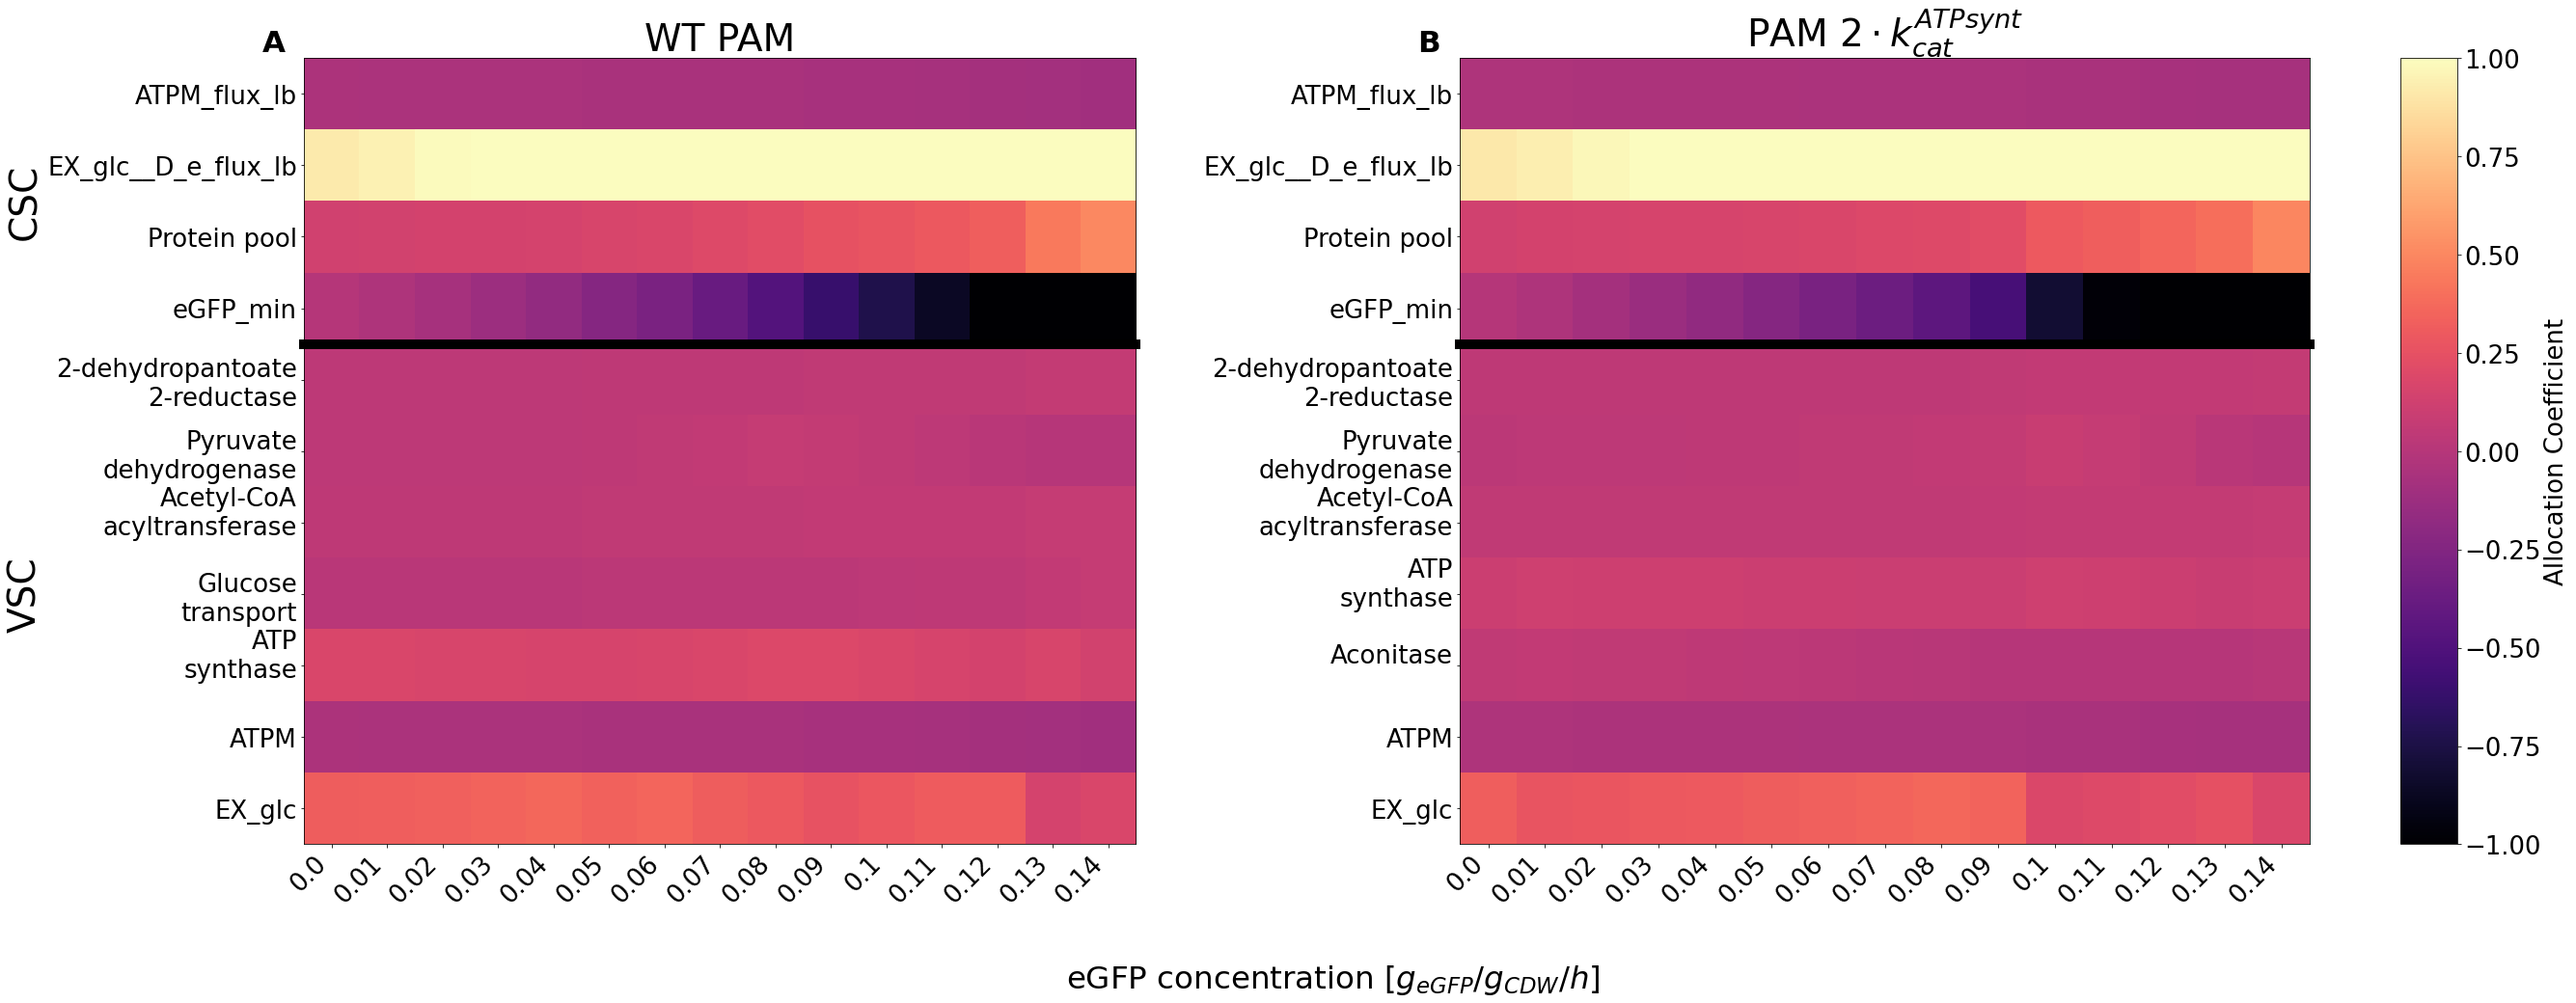

In [48]:
#create 1 big plot
fontsize = 26
vmin =-1
vmax=1
width = 40
height = 15
cmap = 'magma'

# gridspec inside gridspec
fig = plt.figure(layout = 'constrained')

gs0 = gridspec.GridSpec(1, 14, figure=fig, wspace = 25)
gs_pam = gs0[:6]
gs_inc = gs0[7:]

#adjust labels for better readibility
x_csc_label_pam = adjust_heatmap_labels(x_csc_top5_pam)
x_vsc_label_pam = adjust_heatmap_labels(x_vsc_top5_pam)


fig_pam = make_heatmap_subfigure(results = results_pam, csc_matrix=csc_top5_pam, vsc_matrix =vsc_top5_pam,cbar =False,title = 'WT PAM',
                                   x_csc=x_csc_label_pam, x_vsc=x_vsc_label_pam, yaxis = eGFP_RANGE, fig = fig, grdspc = gs_pam,
                                   annotate = 'A', vmin = vmin, vmax=vmax, fontsize = fontsize, cmap = cmap)

# adjust labels for better readibility
x_csc_label_atp = adjust_heatmap_labels(x_csc_top5_atp)
x_vsc_label_atp = adjust_heatmap_labels(x_vsc_top5_atp)


fig_inc = make_heatmap_subfigure(results = results_atp, csc_matrix=csc_top5_atp, vsc_matrix =vsc_top5_atp, ylabels = False,
                                 title = 'PAM $2\cdot k^{ATPsynt}_{cat}$', x_csc=x_csc_label_atp, x_vsc=x_vsc_label_atp, yaxis = eGFP_RANGE, 
                                 fig = fig, grdspc=gs_inc, annotate = 'B',  vmin = vmin, vmax=vmax, fontsize = fontsize, cmap = cmap)

#set common x axis title
ax_xlabel = fig.add_subplot(gs0[0, :2])
ax_xlabel.set_xticks([])
ax_xlabel.set_yticks([])
ax_xlabel.set_frame_on(False)
ax_xlabel.set_xlabel('eGFP concentration [$g_{eGFP}/g_{CDW}/h$]', fontsize = fontsize*1.25)
ax_xlabel.xaxis.set_label_coords(6, -.15)

fig.set_figwidth(width)
fig.set_figheight(height)
fig.align_labels()

fig.savefig('Figure3_sensitivities_protein-overproduction.png', dpi =200,bbox_inches='tight')

## 4.2 plot normalized growth rate as function of eGFP concentration
Similar to what has been done by [Alter et al. (2021)](https://journals.asm.org/doi/10.1128/mSystems.00625-20)

In [ ]:
#get eGFP data from Bienick et al. (2014)
egfp_exp = pd.read_excel(eGFP_BEINICK_DATA_PATH, sheet_name='eGFPvsMu')
mu_wt = 0.75

egfp_exp['mu_normalized'] = egfp_exp['Growth rate'].apply(lambda x: x/mu_wt)
egfp_exp['mu_error_normalized'] = egfp_exp['Growth rate error'].apply(lambda x: x/mu_wt)

In [ ]:
fig, ax = plt.subplots()
ax.plot(results_pam['results']['eGFP'], results_pam['results']['mu_normalized'], label = 'default PAM')
ax.plot(results_inc['results']['eGFP'], results_inc['results']['mu_normalized'], label = 'PAM with $\phi_{E} = 0.31 g_{P}/g_{CDW}$')
ax.plot(results_atp['results']['eGFP'], results_atp['results']['mu_normalized'], label = 'PAM with $2 \cdot k_{cat,ATPsynt}$')

ax.scatter(egfp_exp['eGFP concentration'], egfp_exp['mu_normalized'],
                   color='purple', marker='o', s=30, linewidths=1.3,
                   facecolors=None, zorder=0,
                   label='Bienick et al. (2014)')
ax.errorbar(egfp_exp['eGFP concentration'], egfp_exp['mu_normalized'], 
            yerr= egfp_exp['mu_error_normalized'], xerr = egfp_exp['eGFP concentration error'],
           fmt="o", color='purple')


# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(15)
ax.set_xlabel('eGFP concentration [g_egfp/gDW]', fontsize = 15)
ax.set_ylabel('normalized growth rate [h-1]', fontsize =15)

ax.legend(fontsize=8, edgecolor='white', facecolor='white', framealpha=1)


plt.show()

fig.savefig('SuppFigure3_eGFP-normalized_mu.png', dpi =200,bbox_inches='tight')

## 4.3 plot predicted exchange rates
Similar to what has been done by [Alter et al. (2021)](https://journals.asm.org/doi/10.1128/mSystems.00625-20)

In [ ]:
fontsize = 10

#plot flux changes with eGFP concentration
import matplotlib.transforms as mtransforms
fig, axs = plt.subplot_mosaic([['A', 'B'], ['C', 'D'], ['E', '']],
                              layout='constrained', dpi =100)
for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontfamily='serif', weight = 'bold')

rxn_id = ['EX_ac_e', 'EX_co2_e', 'EX_o2_e', 'EX_for_e', BIOMASS_RXNID]
ylabels = ['Acetate excretion [$mmol_{ac}/g_{CDW}/h$]', 'CO2 excretion [$mmol_{CO2}/g_{CDW}/h$]', 
           'Oxygen uptake [$mmol_{O2}/g_{CDW}/h]$', 'Formate excretion [$mmol_{for}/g_{CDW}/h$]','Growth rate [$h^{-1}$]']
# fig, axs = plt.subplots(2,2, dpi=100)
for i,r in enumerate(rxn_id):
    ax_label = ['A', 'B', 'C', 'D', 'E'][i]
    ax = axs[ax_label]
    if r != BIOMASS_RXNID:
        ax.set_ylim([0,27])
    # plot simulation
    line_pam = ax.plot(eGFP_RANGE, [abs(f[r]) for f in results_pam['fluxes']], linewidth=2.5,
            zorder=5, color ='#440154')
    
    # plot simulation with increases protein capacity
    line_atp = ax.plot(eGFP_RANGE, [abs(f[r]) for f in results_atp['fluxes']],linewidth=2.5,
            zorder=5, color = '#21918c')
   
    
    # options
    ax.set_xlabel('eGFP concentration [g_egfp/gDW]', fontsize = fontsize)
    ax.set_ylabel(ylabels[i], fontsize = fontsize)
    # set grid
    ax.grid(True, axis='both', linestyle='--', linewidth=0.5, alpha=0.6   )
    ax.set_axisbelow(True)
    # show legend
    # ax.legend(fontsize=8, edgecolor='white', facecolor='white', framealpha=1)
    
axs[''].axis('off')
# Manually create legend handles (patches)
blue_patch = matplotlib.patches.Patch(color='#440154', label='default PAM')
orange_patch = matplotlib.patches.Patch(color='#21918c', label='PAM with $2 \cdot k_{cat,ATPsynt}$')

# Add legend to bottom-right ax
axs[''].legend(handles=[blue_patch, orange_patch], loc='center', fontsize = fontsize+7)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.2)
fig.set_figheight(13)
fig.set_figwidth(10)
fig.savefig('SuppFigure3_simulated-physiology.png')
